# Parametric Heteroscedastic Model

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaGaussianProcesses/AbstractGPs.jl/blob/master/examples/parametric-heteroscedastic/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/AbstractGPs.jl/dev/examples/parametric-heteroscedastic/).*

This example is a small extension of the standard GP regression problem, in which the
observation noise variance is a function of the input.
It is assumed to be a simple quadratic form, with a single unknown
scaling parameter, in addition to the usual lengthscale and variance parameters
of the GP.
A point estimate of all parameters is obtained using type-II maximum likelihood,
as per usual.

In [1]:
using AbstractGPs
using AbstractGPsMakie
using CairoMakie
using KernelFunctions
using LinearAlgebra
using Literate
using Optim
using ParameterHandling
using Random
using Zygote

Specify simple GP:

In [2]:
build_gp(θ) = GP(0, θ.s * with_lengthscale(SEKernel(), θ.l));

Observation variance is some scaling of $x^2$:

In [3]:
observation_variance(θ, x::AbstractVector{<:Real}) = Diagonal(θ.σ² .* x .^ 2);

Specify hyperparameters:

In [4]:
flat_init_params, unflatten = ParameterHandling.value_flatten((
    s=positive(1.0), l=positive(3.0), σ²=positive(0.1)
));
θ_init = unflatten(flat_init_params);

Build inputs:

In [5]:
const x = range(0.0, 10.0; length=100);
const y = rand(Xoshiro(123456), build_gp(θ_init)(x, observation_variance(θ_init, x)));

Specify objective function:

In [6]:
function objective(θ)
    f = build_gp(θ)
    Σ = observation_variance(θ, x)
    return -logpdf(f(x, Σ), y)
end;

Optimise the hyperparameters. They've been initialised near the correct values, so
they ought not to deviate too far.

In [7]:
result = optimize(
    objective ∘ unflatten,
    θ -> only(Zygote.gradient(objective ∘ unflatten, θ)),
    flat_init_params + 0.01 * randn(Xoshiro(123456), length(flat_init_params)),
    LBFGS(;
        alphaguess=Optim.LineSearches.InitialStatic(; scaled=true),
        linesearch=Optim.LineSearches.BackTracking(),
    ),
    Optim.Options(; iterations=4_000);
    inplace=false,
);
θ_final = unflatten(result.minimizer);

Construct the posterior GP with the optimal model parameters:

In [8]:
Σ_obs_final = observation_variance(θ_final, x);
fx_final = build_gp(θ_final)(x, Σ_obs_final);
f_post = posterior(fx_final, y);

Plot the results, making use of [AbstractGPsMakie](https://github.com/JuliaGaussianProcesses/AbstractGPsMakie.jl):

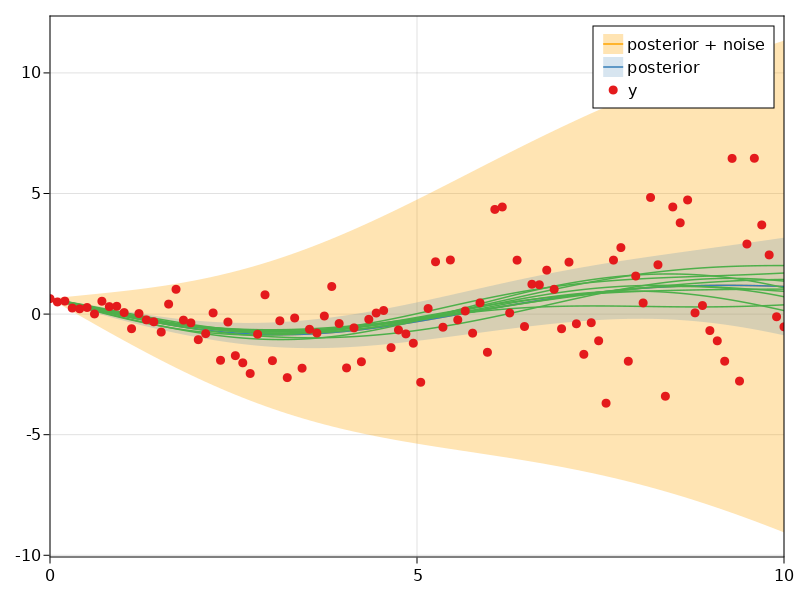

In [9]:
using CairoMakie.Makie.ColorSchemes: Set1_4

set_theme!(
    palette=(color=Set1_4,),
    patchcolor=(Set1_4[2], 0.2),
    Axis=(limits=((0, 10), nothing),),
)

let
    fig = Figure()
    ax = Axis(fig[1, 1])
    plot!(ax, x, f_post(x, Σ_obs_final); bandscale=3, label="posterior + noise", color=(:orange, 0.3))
    plot!(ax, x, f_post(x, 1e-9); bandscale=3, label="posterior")
    gpsample!(ax, x, f_post(x, 1e-9); samples=10, color=Set1_4[3])
    scatter!(ax, x, y; label="y")
    axislegend(ax)
    fig
end

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*